<p><img src="http://smallbizblast.typepad.com/photos/uncategorized/2008/04/14/cartoon.gif" /></p>

This notebook summarizes a few days of investigation on the kaggle dataset (https://www.kaggle.com/c/GiveMeSomeCredit).

It shows the use of a mix of python and R libraries, showing how to interact with both languages. 

For imputing missing data, R package Amelia is used. Amelia is a program from a few Harvard folks (http://gking.harvard.edu/amelia). The package is named after Amelia Earhart, a famous American woman aviator who went missing over the ocean.

Amelia actually performs multiple imputation. In single imputation, we guess that missing value one time (perhaps based on the means of observed values, or a random sampling of those values). In multiple imputation, we instead draw multiple values for each missing value, effectively building multiple datasets, each of which replaces the missing data in a different way.

The classifiers are tuned using the python library Optunity (http://optunity.readthedocs.org/en/latest/index.html). Optunity is a library containing various optimizers for hyperparameter tuning. Hyperparameter tuning is a recurrent problem in many machine learning tasks, both supervised and unsupervised. This package provides several distinct approaches to solve such problems including some helpful facilities such as cross-validation and a plethora of score functions.

In this notebook, it is shown how to use Optunity in combination with other machine learning libraries to classify this Dataset. The cool part is that Optunity is used to choose the best approach from a set of available learning algorithms and optimize hyperparameters in one go. We will try the following learning algorithms:

- Naive Bayes
- Gradient Boosting Classifier
- SVM
- Random Forest
- kNN
- Neural Networks, using Theano and Lasagne
- Extreme Gradient Boosting (XGBoost)

Thanks for Sebastian Raschka's post on Ensemble Classifiers (http://sebastianraschka.com/Articles/2014_ensemble_classifier.html), an Ensemble Classifier which combines a subset of previously tuned classifiers is built. A specific weight is assigned to each classifier. In order to work with the weights, we collect the predicted class probabilities for each classifier, multiply it by the classifier weight, and take the average. Here as well Optunity is used to tune the Ensemble Classifier, i.e. to choose the best weights using particle swarm optimization method (https://en.wikipedia.org/wiki/Particle_swarm_optimization).

Finally, this process is repeated for each Amelia imputed dataset. Thus, we end up with a set of tuned ensemble classifiers. We collect again the predicted class probabilities for each ensemble classifier and take the average. 

These average probabilites are considered as the final resul to be submitted to Kaggle.

**Caveats**: 

This notebook could only be run on a limited resource (within a vagrant instance on my personal laptop):

1. the subset of classifiers had to be limited to:
    - Naive Bayes
    - Neural Networks
    - XGBoost
2. the amelia datasets has been downsampled to ~10% of the original size
3. the number of amelia datasets has been limited to 30


## Exploration

First thing to do is data exploration, in order to detect eventually outliers, missing data, corrupted data, predictor distributions, etc...

In [1]:
import pandas as pd
import numpy as np
%load_ext rpy2.ipython  

train = pd.read_csv("../data/cs-training.csv")

test = pd.read_csv("../data/cs-test.csv")

df = pd.concat((train,test))
df = df.drop(["SeriousDlqin2yrs"],axis=1)
df = df.drop(["Unnamed: 0"],axis=1)

In [2]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
RevolvingUtilizationOfUnsecuredLines,251503,5.750415,229.633980,0,0.029977,0.153575,0.561293,50708
age,251503,52.339694,14.775120,0,41.000000,52.000000,63.000000,109
NumberOfTime30-59DaysPastDueNotWorse,251503,0.434245,4.335643,0,0.000000,0.000000,0.000000,98
DebtRatio,251503,349.562468,1884.792016,0,0.174330,0.365612,0.861754,329664
MonthlyIncome,201669,6744.818167,25717.610237,0,3400.000000,5400.000000,8212.000000,7727000
NumberOfOpenCreditLinesAndLoans,251503,8.453064,5.145194,0,5.000000,8.000000,11.000000,85
NumberOfTimes90DaysLate,251503,0.278370,4.312539,0,0.000000,0.000000,0.000000,98
NumberRealEstateLoansOrLines,251503,1.016155,1.121935,0,0.000000,1.000000,2.000000,54
NumberOfTime60-89DaysPastDueNotWorse,251503,0.252466,4.299204,0,0.000000,0.000000,0.000000,98
NumberOfDependents,244953,0.761995,1.123905,0,0.000000,0.000000,1.000000,43


### NaNs statistics

In [3]:
1-df.describe().T["count"]/df.shape[0]

RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.198145
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.026043
Name: count, dtype: float64

### Predictor Distributions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f29ec553350>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f29ec009e10>]], dtype=object)

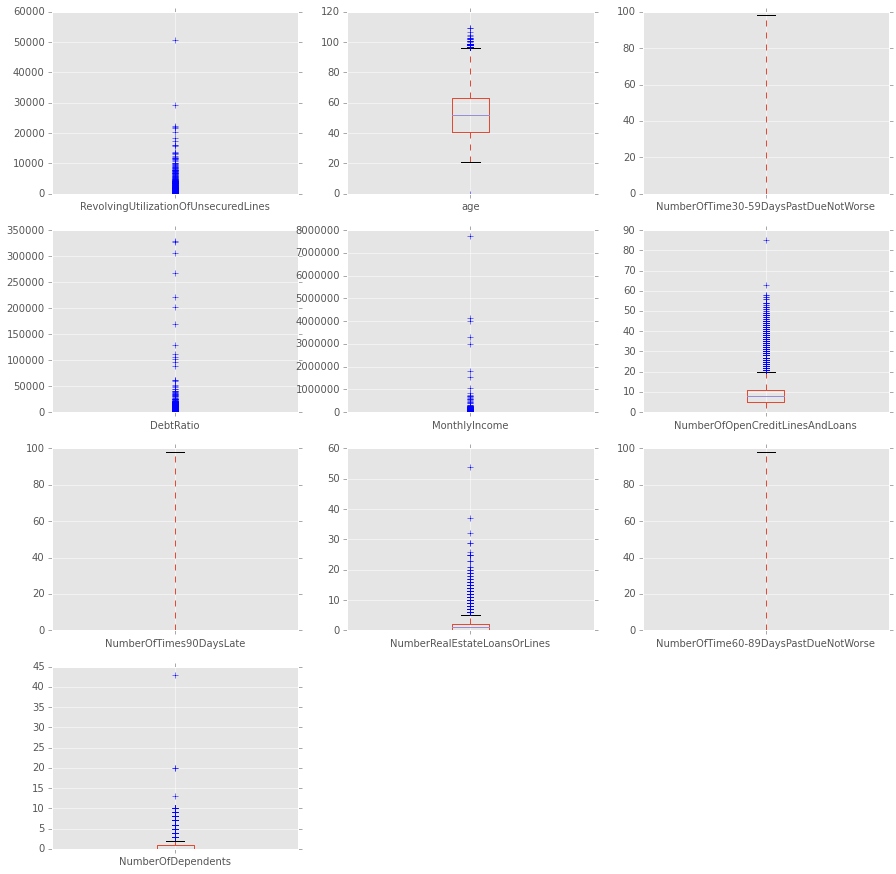

In [4]:
import matplotlib.pyplot as plt
import math
%matplotlib inline
plt.style.use('ggplot')

ncols=3
figsize=(15,15)
nrows=int(math.ceil(float(len(df.columns))/ncols))
df.plot(kind="box",subplots=True,layout=(nrows,ncols),figsize=figsize)

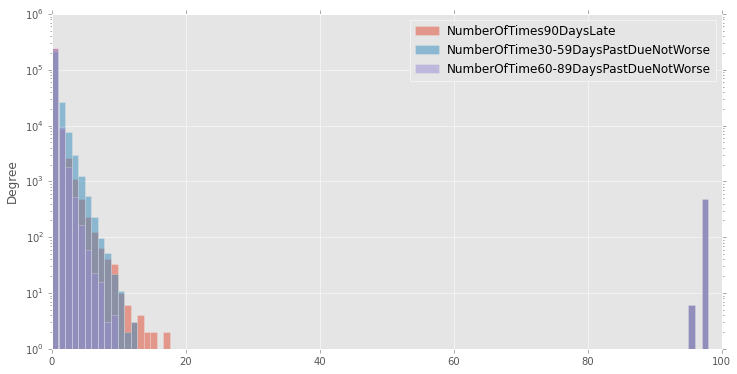

In [5]:
df[["NumberOfTimes90DaysLate","NumberOfTime30-59DaysPastDueNotWorse","NumberOfTime60-89DaysPastDueNotWorse"]].plot(kind="hist",logy=True,alpha=0.5,bins=100,figsize=(12,6))

**NumberOfTimes90DaysLate** 

**NumberOfTime30-59DaysPastDueNotWorse**

**NumberOfTime60-89DaysPastDueNotWorse**
    - Distributions highly skewed.
    - Strange values [96,98] are observed for the preditors. These will be replaced by NA and then imputed
**RevolvingUtilizationOfUnsecuredLines**
    - Distribution highly skewed.
    - Based on the predictor definition, it looks weird that this predictor takes values above 1. These will be
    replaced by NA and then imputed
**NumberOfDependents**
    - Disribution highly skewed.

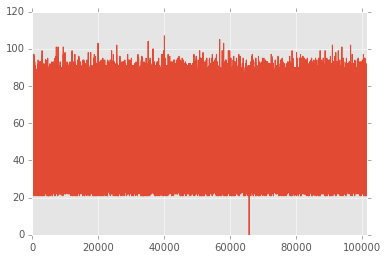

In [6]:
df["age"].plot()

**age**

    - Age cannot be 0... having already a credit line before being born, so crippy. Naively maybe, these will be
    replaced by NA and then imputed

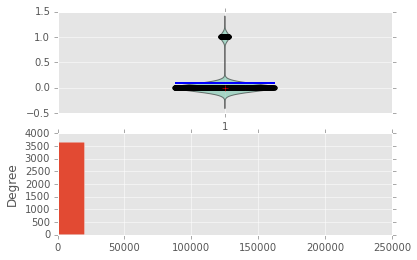

In [7]:
import statsmodels.api as sm
fig = plt.figure()
ax = fig.add_subplot(211)
sm.graphics.beanplot([df["MonthlyIncome"][df["DebtRatio"] > df["DebtRatio"].quantile(.95)].dropna()], ax=ax, jitter=True);
ax = fig.add_subplot(212)
df["DebtRatio"][df["MonthlyIncome"] <= 1].plot(kind="hist",ax=ax)

In [8]:
df[["MonthlyIncome","DebtRatio"]][df["DebtRatio"]>50000]

,MonthlyIncome,DebtRatio
4854,NaN,168835.0
7513,NaN,110952.0
36600,NaN,326442.0
46102,NaN,52112.0
53682,1,61106.5
58900,NaN,220516.0
60152,NaN,329664.0
66785,NaN,61907.0
69845,NaN,101320.0
103041,NaN,106885.0


**DebtRatio**
    - Distribution are highly right skewed. 
**MonthlyIncome**
    - Distribution are highly right skewed. 
    - "NaN" as MonthlyIncome leads to DebtRatio >> 50000 and these values are much higher with respect to the rest of the DebtRatio values. The hypothesis taken here is that as the MonthlyIncome should really low with respect to the amount of Debt in these cases. NaNs will be replaced with 0.

### Class Distribution

0.93316

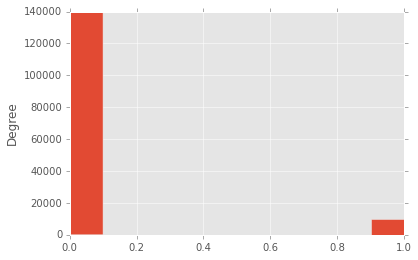

In [9]:
train["SeriousDlqin2yrs"].plot(kind="hist")
len(train[train["SeriousDlqin2yrs"]==0])/float(len(train))

**SeriousDlqin2yrs**
    - A severe class imbalance is observed. This will have to be taken in consideration during the training
    process. The accuracy of the predictive algorithm will have to be higher than 93.3%

## Preprocessing

### Imputation

Imputation is performed "naively" on the complete dataset, i.e. train and test.

NaNs are assigned to some predictor observations, as commented during the Exploration Process.

In [10]:
inp2imp_path = '../data/outputs'
imp_path ='../data/amelia'
m_imp = 30
n_folds_opt = 8
num_evals_m_opt = 40
num_evals_e_opt = 12
n_iter_mod=1
n_iter_ens=1 
n_iter_under=1
results_path ='../data/results' # use your path
undersample_level = 1

search = {'algorithm': {
                        'nnets': None,
                        'naive-bayes' : None,
                        'extreme-gboost': {'n_estimators': [100, 101],
                                      'colsample_bytree': [0.5, 1.0],
                                      'max_depth': [3, 6]}
                        }
         }

In [11]:
inp2imp_path = '../data/outputs'
imp_path ='../data/amelia'

In [12]:
import os

df.loc[:,("NumberOfTimes90DaysLate")].replace(to_replace=[96,98],value=[None,None],inplace=True)
df.loc[:,("NumberOfTime30-59DaysPastDueNotWorse")].replace(to_replace=[96,98],value=[None,None],inplace=True)
df.loc[:,("NumberOfTime60-89DaysPastDueNotWorse")].replace(to_replace=[96,98],value=[None,None],inplace=True)
df["age"].replace(to_replace=[0],value=[None],inplace=True)
df.loc[df.loc[:,"RevolvingUtilizationOfUnsecuredLines"]>1,"RevolvingUtilizationOfUnsecuredLines"]=1
df.loc[df["DebtRatio"]>50000,("MonthlyIncome")].replace(to_replace=[None],value=[0],inplace=True)

df.loc[df["MonthlyIncome"].isnull(),("DebtRatio")]=None

## dataframe is exported to csv for imputation using the R package Amelia
## because the rpy2 converted dataframe is not accepted by Amelia
if not os.path.exists(inp2imp_path):
    os.makedirs(inp2imp_path)
df.to_csv(inp2imp_path + '/for_imputation.csv',index=False)

In [13]:
# Necessary in order to avoid memory issues using RPY2
import gc
gc.collect()

5272

The imputation model in Amelia assumes that the complete data (that is, both observed and unobserved) are multivariate normal. If we denote the (n × k) dataset as D (with observed part ${D_{obs}}$ and unobserved part ${D_{mis}}$), then this assumption is

$${D ∼ N_k({\mu}, {\sigma})}$$

which states that D has a multivariate normal distribution with mean vector ${\mu}$ and covariance matrix ${\sigma}$. The multivariate normal distribution is often a crude approximation to the true distribution of the data, yet there is evidence that this model works as well as other, more complicated models even in the face of categorical or mixed data. Furthermore, transformations of many types of variables can often make this normality assumption more plausible.

This is why highly skewed predictor distributions are transformed before being injerted in Amelia.

In [14]:
%%R -i imp_path,m_imp
library("Amelia")

df = read.csv("../data/outputs/for_imputation.csv")
bds = matrix(c(match("NumberOfDependents",names(df)), 0, Inf),nrow = 1, ncol = 3)
sqrts = c(match("NumberOfTimes90DaysLate",names(df)),
          match("NumberOfTime30.59DaysPastDueNotWorse",names(df)),
          match("NumberOfTime60.89DaysPastDueNotWorse",names(df)),
          match("MonthlyIncome",names(df)),
          match("DebtRatio",names(df)),
          match("RevolvingUtilizationOfUnsecuredLines",names(df)))

imputed = amelia(df,m=m_imp,sqrts=sqrts,bounds=bds,collect=TRUE)

dir.create(imp_path, recursive = TRUE)
write.amelia(imputed, file.stem = paste(imp_path,"/train_and_test_imputed",sep=""))

/home/vagrant/.virtualenvs/venvpy2/local/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: Rcpp

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/vagrant/.virtualenvs/venvpy2/local/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: ## 
## Amelia II: Multiple Imputation
## (Version 1.7.3, built: 2014-11-14)
## Copyright (C) 2005-2015 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 

  res = super(Function, self).__call__(*new_args, **new_kwargs)


-- Imputation 1 --

  1  2  3

-- Imputation 2 --

  1  2  3

-- Imputation 3 --

  1  2  3

-- Imputation 4 --

  1  2  3

-- Imputation 5 --

  1  2  3

-- Imputation 6 --

  1  2  3

-- Imputation 7 --

  1  2  3

-- Imputation 8 --

  1  2  3

-- Imputation 9 --

  1  2  3

-- Imputation 10 --

  1  2  3

-- Imputation 11 --

  1  2  3

-- Imputation 12 --

  1  2  3

-- Imputation 13 --

  1  2  3

-- Imputation 14 --

  1  2  3

-- Imputation 15 --

  1  2  3

-- Imputation 16 --

  1  2  3

-- Imputation 17 --

  1  2  3

-- Imputation 18 --

  1  2  3

-- Imputation 19 --

  1  2  3

-- Imputation 20 --

  1  2  3

-- Imputation 21 --

  1  2  3

-- Imputation 22 --

  1  2  3

-- Imputation 23 --

  1  2  3

-- Imputation 24 --

  1  2  3

-- Imputation 25 --

  1  2  3

-- Imputation 26 --

  1  2  3

-- Imputation 27 --

  1  2  3

-- Imputation 28 --

  1  2  3

-- Imputation 29 --

  1  2  3

-- Imputation 30 --

  1  2  3



In [15]:
# Necessary in order to avoid memory issues using RPY2
gc.collect()

170

### Training

As commented before, a strong class imbalance is present in this dataset. Here, I try to use undersampling in order to reduce this effect. Moreover, reducing the dataset size is such that it would speed up the learning process 

Not sure if it is the best approach with this dataset... 

In [ ]:
import numpy as np

def undersampling(X,y,level=1,bs_minority=False):
    posI = np.where(y==1)[0]
    negI = np.where(y==0)[0]
        
    subNegI = np.random.choice(negI,int(len(negI)*(1-level) + len(posI)),replace=False)
    
    if bs_minority:
        subPosI = np.random.choice(posI,len(posI),replace=True)
    else:
        subPosI = posI

    X_resampled=X[np.concatenate((subNegI,subPosI)),]
    y_resampled=y[np.concatenate((subNegI,subPosI)),]
    
    return X_resampled, y_resampled

Following class is in order to use the Scikit Learn Gradient Boosting Classifier with early stopping. The objective is to speed up again the learning process.

In [ ]:
from sklearn.ensemble._gradient_boosting import predict_stage

class Monitor():
    """Monitor for early stopping in Gradient Boosting for classification.

    The monitor checks the validation loss between each training stage. When
    too many successive stages have increased the loss, the monitor will return
    true, stopping the training early.

    Parameters
    ----------
    X_valid : array-like, shape = [n_samples, n_features]
      Training vectors, where n_samples is the number of samples
      and n_features is the number of features.
    y_valid : array-like, shape = [n_samples]
      Target values (integers in classification, real numbers in
      regression)
      For classification, labels must correspond to classes.
    max_consecutive_decreases : int, optional (default=5)
      Early stopping criteria: when the number of consecutive iterations that
      result in a worse performance on the validation set exceeds this value,
      the training stops.
    """

    def __init__(self, X_valid, y_valid, max_consecutive_decreases=5):
        self.X_valid = X_valid
        self.y_valid = y_valid
        self.max_consecutive_decreases = max_consecutive_decreases
        self.losses = []


    def __call__(self, i, clf, args):
        if i == 0:
            self.consecutive_decreases_ = 0
            self.predictions = clf._init_decision_function(self.X_valid)

        predict_stage(clf.estimators_, i, self.X_valid, clf.learning_rate,
                      self.predictions)
        self.losses.append(clf.loss_(self.y_valid, self.predictions))

        if len(self.losses) >= 2 and self.losses[-1] > self.losses[-2]:
            self.consecutive_decreases_ += 1
        else:
            self.consecutive_decreases_ = 0

        if self.consecutive_decreases_ >= self.max_consecutive_decreases:
            print("Too many consecutive decreases of loss on validation set"
                  "({}): stopping early at iteration {}.".format(self.consecutive_decreases_, i))
            return True
        else:
            return False

The function **create_model** instantiates the classifier before training.

In [ ]:
import optunity
import optunity.metrics
from functools import partial

# k nearest neighbours
from sklearn.neighbors import KNeighborsClassifier
# support vector machine classifier
from sklearn.svm import SVC
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
# Random Forest
from sklearn.ensemble import RandomForestClassifier
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifieran early stopping process for 
# Extreme Gradient Boosting
from xgboost import XGBClassifier
# Neural Networks
from lasagne.layers import DenseLayer
from lasagne.layers import InputLayer
from lasagne.layers import DropoutLayer
from lasagne.nonlinearities import softmax
from lasagne.updates import nesterov_momentum
from lasagne.objectives import categorical_crossentropy
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import TrainSplit

from sklearn import preprocessing

def create_svm(kernel, C, gamma, degree, coef0):
    """A generic SVM training function, with arguments based on the chosen kernel."""
    if kernel == 'linear':
        model = SVC(kernel=kernel, C=C)
    elif kernel == 'poly':
        model = SVC(kernel=kernel, C=C, degree=degree, coef0=coef0)
    elif kernel == 'rbf':
        model = SVC(kernel=kernel, C=C, gamma=gamma)
    else:
        model=None
    return model

def create_nnets(num_features,num_classes):
    
    layers0 = [('input', InputLayer),
           ('dense0', DenseLayer),
           ('dropout', DropoutLayer),
           ('dense1', DenseLayer),
           ('output', DenseLayer)]
    
    model = NeuralNet(layers=layers0,
                 input_shape=(None, num_features),
                 dense0_num_units=2*num_features,
                 dense1_num_units=2*num_features,
                 output_num_units=num_classes,
                 output_nonlinearity=softmax,
                 objective_loss_function = categorical_crossentropy,
                 dropout_p=0.8,
                 update=nesterov_momentum,
                 update_learning_rate=0.05,
                 update_momentum=0.9,
                 train_split=TrainSplit(eval_size=0.2),
                 verbose=0,
                 max_epochs=30)
    
    return model

def create_model(algorithm, num_features=None, num_classes=None, n_neighbors=None, n_estimators=None, 
                 max_features=None,kernel=None, C=None, gamma=None, degree=None, coef0=None, max_depth=None, 
                 min_samples_leaf=None, colsample_bytree=None, eval_set=None, ensemble_weights=None, ensemble_confs=None):
    if algorithm == 'k-nn':
        model = KNeighborsClassifier(n_neighbors=int(n_neighbors))
    elif algorithm == 'SVM':
        model = create_svm(kernel, C, gamma, degree, coef0)
    elif algorithm == 'naive-bayes':
        model = GaussianNB()
    elif algorithm == 'random-forest':
        model = RandomForestClassifier(n_estimators=int(n_estimators),
                                       max_features=max_features,
                                       max_depth=int(max_depth), 
                                       min_samples_leaf=int(min_samples_leaf))
    elif algorithm == 'gradient-boost':
        model = GradientBoostingClassifier(n_estimators=int(n_estimators),
                                           max_features=max_features,
                                           max_depth=int(max_depth), 
                                           min_samples_leaf=int(min_samples_leaf))
        model.fit = partial(model.fit,
                            monitor = Monitor())
    elif algorithm == 'extreme-gboost':
        model = XGBClassifier(n_estimators=int(n_estimators),
                                           colsample_bytree=colsample_bytree,
                                           max_depth=int(max_depth),nthread=2)
        model.fit = partial(model.fit,
                            early_stopping_rounds = 20, 
                            eval_metric = 'auc',
                            eval_set = eval_set,
                            verbose=False)
    elif algorithm == 'nnets':
        model = create_nnets(num_features=num_features,num_classes=num_classes)
    elif algorithm == 'ensemble':
        clfs = []
        for conf in ensemble_confs:            
            clf = create_model(num_features=num_features, num_classes=num_classes,
                                 eval_set=eval_set, **conf)
            clfs.append(clf)
        model = EnsembleClassifier(clfs=clfs, weights=ensemble_weights , voting='soft')
    else:
        model=None
    return model

### Train & Predict Script

In [ ]:
from glob import glob
from ensemble import EnsembleClassifier
from collections import OrderedDict
from datetime import datetime
import time
from sklearn.cross_validation import StratifiedKFold
from sklearn.base import clone
from functools import partial

allFiles = glob(imp_path + "/*.csv")

mi_probabilities = []

for file_ in allFiles:
    
    print "dataset being processed: {filename}".format(filename=file_)
    time.sleep(0.1)
    
    df_imputed_R = pd.read_csv(file_,index_col=0)
    
    df_imp = df_imputed_R.values.astype(np.float32)
    data = df_imp[0:len(train.index),:] 
    test = df_imp[len(train.index):,:] 
    labels = train["SeriousDlqin2yrs"].values.astype(np.int32)
    
    num_features = np.shape(data)[1]
    num_classes = len(np.unique(labels))
    
    model_per_stratified_niterfolds = []
    for ni in range(n_iter_mod):
        iter_folds = [list(testf) for trainf, testf in StratifiedKFold(labels, n_folds=n_folds_opt, shuffle=True)]
        model_per_stratified_niterfolds.append(iter_folds)
        
    ensemble_per_stratified_niterfolds = []
    for ni in range(n_iter_ens):
        iter_folds = [list(testf) for trainf, testf in StratifiedKFold(labels, n_folds=n_folds_opt, shuffle=True)]
        ensemble_per_stratified_niterfolds.append(iter_folds)
        
    final_stratified_niterfolds = []
    for ni in range(n_iter_under):
        iter_folds = [list(testf) for trainf, testf in StratifiedKFold(labels, n_folds=n_folds_opt, shuffle=True)]
        final_stratified_niterfolds.append(iter_folds)
        
    optimal_confs = []
    optimal_weights = None
    
    @optunity.cross_validated(x=data, y=labels, num_folds=n_folds_opt,num_iter=n_iter_mod, folds=model_per_stratified_niterfolds )
    def model_performance(x_train, y_train, x_test, y_test, 
                    algorithm, n_neighbors=None, n_estimators=None, max_features=None,
                    kernel=None, C=None, gamma=None, degree=None, coef0=None, max_depth=None,
                    min_samples_leaf=None, colsample_bytree=None, confs=None, **kwargs):
        
        x_train,y_train = undersampling(x_train,y_train,undersample_level,bs_minority=True)
        
        scaler = preprocessing.StandardScaler().fit(x_train)
        x_train_scaled = scaler.transform(x_train)
        x_test_scaled = scaler.transform(x_test)
        
        weights = dict((key,value) for key, value in kwargs.iteritems() if key.startswith('weight'))
        weights = [value for key,value in sorted(weights.items(),key=lambda x:x[0])]
                
        model = create_model(algorithm=algorithm, num_features=num_features, num_classes=num_classes, 
                             n_neighbors=n_neighbors, n_estimators=n_estimators, max_features=max_features, 
                             kernel=kernel, C=C, gamma=gamma, degree=degree, coef0=coef0, max_depth=max_depth,
                             min_samples_leaf=min_samples_leaf, colsample_bytree=colsample_bytree, 
                             eval_set=[(x_test_scaled, y_test)], ensemble_confs=confs, ensemble_weights=weights)
                        
        if model is not None:
            
            model.fit(x_train_scaled, y_train)
            # predict the test set
            if algorithm == 'SVM':
                predictions = model.decision_function(x_test_scaled)
            else:
                predictions = model.predict_proba(x_test_scaled)[:, 1]
            return optunity.metrics.roc_auc(y_test, predictions, positive=True)
        else:
            return 0
    
    @optunity.cross_validated(x=data, y=labels, num_folds=n_folds_opt, num_iter=n_iter_under,folds=final_stratified_niterfolds,aggregator=optunity.cross_validation.list_mean)
    def undersample_performance(x_train, y_train, x_test, y_test, 
                                test_set=None, conf=None, weights=None):

        x_train,y_train = undersampling(x_train,y_train,undersample_level,bs_minority=True)

        scaler = preprocessing.StandardScaler().fit(x_train)
        x_train_scaled = scaler.transform(x_train)
        x_test_scaled = scaler.transform(x_test)
        
        if len(conf)>1:
            model = create_model(algorithm='ensemble',num_features=num_features, num_classes=num_classes,
                                 eval_set=[(x_test_scaled, y_test)], ensemble_confs=conf,ensemble_weights=optimal_weights)
        else:
            model = create_model(num_features=num_features, num_classes=num_classes,
                                 eval_set=[(x_test_scaled, y_test)],**conf[0])
                
        model.fit(x_train_scaled, y_train)
        
        test_set_scaled = scaler.transform(test_set)
        
        predictions = model.predict_proba(test_set_scaled)[:, 1]
        
        return tuple(predictions)

    for algo in search["algorithm"]:
        
        print "algorithm being tuned: {algo}".format(algo=algo)
        time.sleep(0.1)

        search_space = {}
        search_space["algorithm"] = {}
        search_space["algorithm"][algo] = search["algorithm"][algo]
        search_space["algorithm"].update({"dummy":None})

        optimal_model_configuration, model_tuning_info, _ = optunity.maximize_structured(model_performance,
                                                                      search_space=search_space,
                                                                      num_evals=num_evals_m_opt)
        
        if optimal_model_configuration['algorithm'] is not 'dummy':
            optimal_confs.append(optimal_model_configuration)
            
    if optimal_confs and len(optimal_confs)>1:
        
        weights = dict()
        for i,x in enumerate(optimal_confs):
            weights["weight{i}".format(i=i)]=[0,1]
        ensemble_search = {'weights': weights }

        optimal_ensemble_configuration, ensemble_tuning_info, _ = optunity.maximize_structured(
            partial(model_performance,confs=optimal_confs,algorithm='ensemble'),
            num_evals=num_evals_e_opt,
            search_space=weights)

        optimal_weights = OrderedDict(sorted(optimal_ensemble_configuration.items())).values()
            
    probabilities = undersample_performance(test_set = test, conf=optimal_confs, weights = optimal_weights)
    
    mi_probabilities.append(probabilities)
        
final_probabilities = np.mean(np.array(mi_probabilities),axis=0)  


### Export Results for Kaggle

In [ ]:
from datetime import datetime
import os

results = pd.DataFrame(data=final_probabilities,columns=["Probability"])
results.index = results.index + 1
results.index.name = "Id"

if not os.path.exists(results_path):
    os.makedirs(results_path)
    
results.to_csv(results_path + "/{time}-results.csv".format(time=datetime.now()))